In [36]:
#keyword extraction from the data
import requests
import pandas as pd
from datetime import datetime, timedelta

# Define your keywords and date range
keywords = ["rent","property_price","income","mortgage","observations","housing_price","students","visa","migration","immigration","rental_price","studying"]
start_year = 2022
end_year = 2024

# Function to generate monthly date ranges
def generate_monthly_date_ranges(start_year, end_year):
    date_ranges = []
    for year in range(start_year, end_year + 1):
        month_start = 7 if year == start_year else 1
        month_end = 4 if year == end_year else 12
        for month in range(month_start, month_end + 1):
            start_date = datetime(year, month, 1)
            end_date = start_date + timedelta(days=32)
            end_date = end_date.replace(day=1) - timedelta(days=1)
            date_ranges.append((start_date, end_date))
    return date_ranges

# Function to get keyword count data
def get_keyword_counts(keyword, start_date, end_date):
    url = f"http://127.0.0.1:9090/toot/{keyword}?start_date={start_date}&end_date={end_date}&type=count"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if isinstance(data, dict):
            return data.get('count', 0)
        elif isinstance(data, list) and len(data) > 0:
            return data[0].get('count', 0)
        else:
            return 0
    else:
        return None

# Generate the monthly date ranges
date_ranges = generate_monthly_date_ranges(start_year, end_year)

# Create a DataFrame to store the results
results = []

# Fetch data for each keyword and date range
for keyword in keywords:
    for start_date, end_date in date_ranges:
        count = get_keyword_counts(keyword, start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d"))
        if count is not None:
            results.append({
                'keyword': keyword,
                'start_date': start_date.strftime("%Y-%m-%d"),
                'end_date': end_date.strftime("%Y-%m-%d"),
                'count': count
            })

# Convert results to DataFrame
count_df = pd.DataFrame(results)
# count_df.to_csv("keyword_counts.csv", index=False)

In [48]:
#sentiment analysis
import requests
import pandas as pd
from datetime import datetime, timedelta
import re
from textblob import TextBlob

# Define your keywords and date range
keywords = ["rent","property_price","income","mortgage","observations","housing_price","students","visa","migration","immigration","rental_price","studying"]
start_year = 2022
end_year = 2024

# Function to generate monthly date ranges
def generate_monthly_date_ranges(start_year, end_year):
    date_ranges = []
    for year in range(start_year, end_year + 1):
        month_start = 7 if year == start_year else 1
        month_end = 4 if year == end_year else 12
        for month in range(month_start, month_end + 1):
            start_date = datetime(year, month, 1)
            end_date = start_date + timedelta(days=32)
            end_date = end_date.replace(day=1) - timedelta(days=1)
            date_ranges.append((start_date, end_date))
    return date_ranges

# Function to remove HTML tags
def remove_html(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)


# Function to get sentimental scores
def fetch_data(keyword, start_date, end_date):
    url = f"http://127.0.0.1:9090/toot/{keyword}?start_date={start_date}&end_date={end_date}&type=raw"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data for keyword '{keyword}' in date range {start_date} to {end_date}")
        return None
    
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment
    return sentiment.polarity
    
data_range = generate_monthly_date_ranges(start_year, end_year)

sentimetal_scores_list = []

for keyword in keywords:
    for start_date, end_date in data_range:
        data = fetch_data(keyword, start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d"))
        if data:
            total_polarity = 0
            count = 0
            for item in data:
                content = item.get("content", "")
                cleaned_text = remove_html(content)
                sentiment_score = get_sentiment(cleaned_text)
                total_polarity += sentiment_score
                count += 1
            if count > 0:
                average_polarity = total_polarity / count
                sentimetal_scores_list.append({
                    'keyword': keyword,
                    'start_date': start_date.strftime("%Y-%m-%d"),
                    'end_date': end_date.strftime("%Y-%m-%d"),
                    'average_polarity': average_polarity
                })

sentiment_df = pd.DataFrame(sentimetal_scores_list)
# sentiment_df.to_csv("sentiment_scores.csv", index=False)
    

In [49]:
#Unite the two dataframes
import pandas as pd

# Merge the two dataframes on keyword, start_date, and end_date
merged_df = pd.merge(count_df, sentiment_df, on=['keyword', 'start_date', 'end_date'], how='left')

# Fill NaN values in average_polarity with 0
merged_df['average_polarity'] = merged_df['average_polarity'].fillna(0)

# Save the merged dataframe to a new CSV file
merged_df.to_csv('merged_data.csv', index=False)


Plot saved as output/keyword_count_change_plot.html


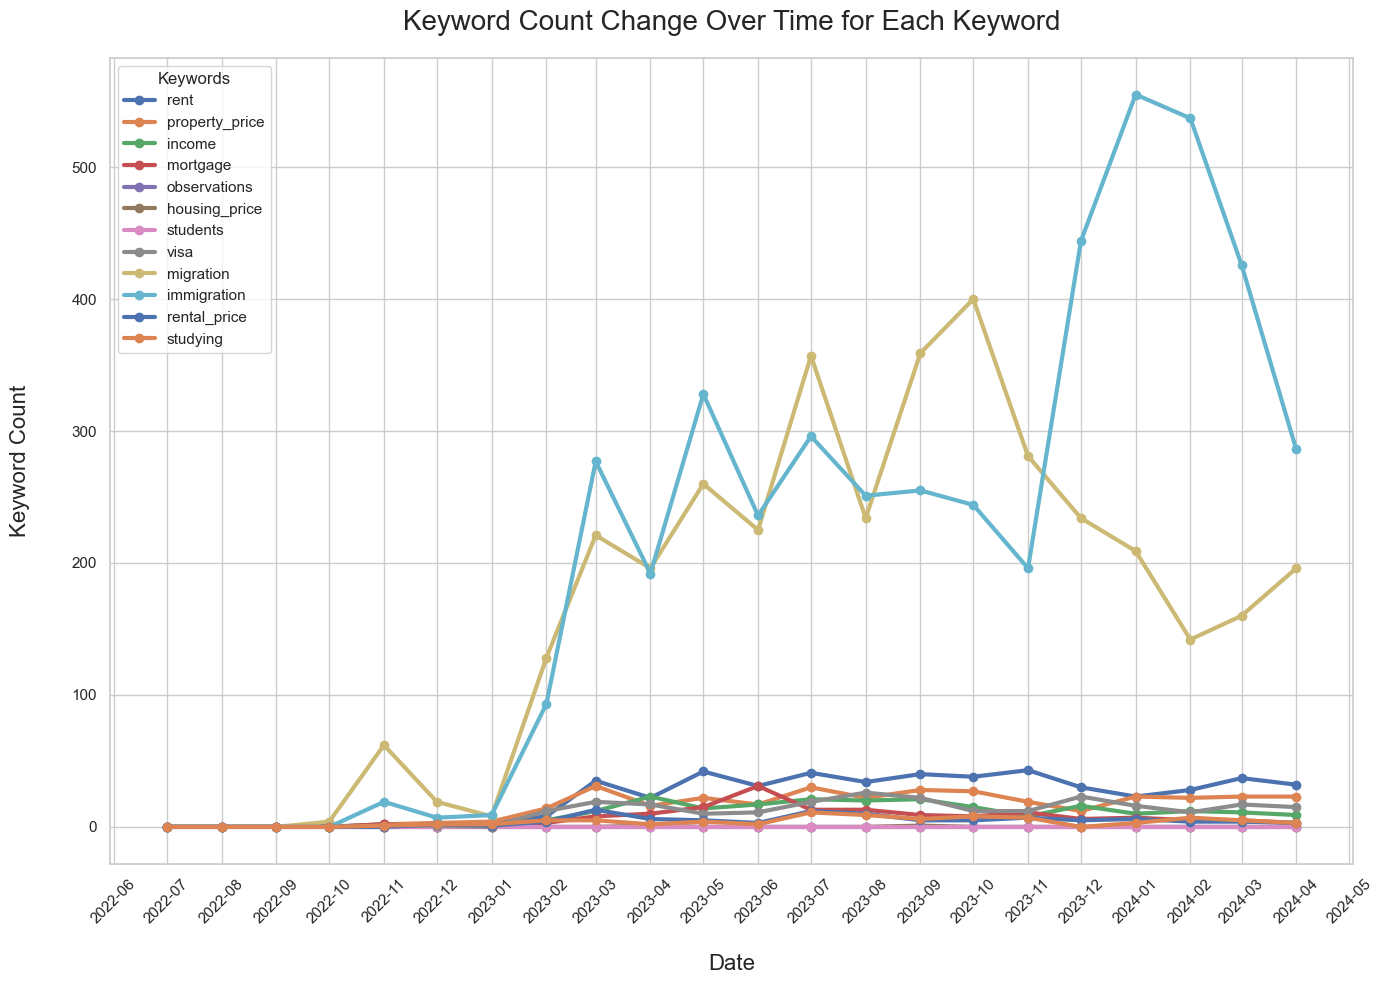

In [50]:
#keyword count plot graph
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import matplotlib.dates as mdates

# Convert the start_date to datetime for better plotting
merged_df['start_date'] = pd.to_datetime(merged_df['start_date'])

# Create the plot
plt.figure(figsize=(14, 10))
sns.set(style="whitegrid")
color_palette = sns.color_palette("tab10", len(merged_df['keyword'].unique()))

for keyword in merged_df['keyword'].unique():
    keyword_data = merged_df[merged_df['keyword'] == keyword]
    plt.plot(keyword_data['start_date'], keyword_data['count'], label=keyword,linewidth=3, marker='o', markersize=6)

plt.xlabel('Date', fontsize=16, labelpad=20)
plt.ylabel('Keyword Count', fontsize=16, labelpad=30)
plt.title('Keyword Count Change Over Time for Each Keyword', fontsize=20, pad=20)
plt.legend(title='Keywords',loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout(pad=3.0)

# Set major locator to month intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as an HTML file
html_filename = 'output/keyword_count_change_plot.html'
mpld3.save_html(plt.gcf(), html_filename)

print(f"Plot saved as {html_filename}")

Plot saved as output/sentiment_socre_change_plot.html


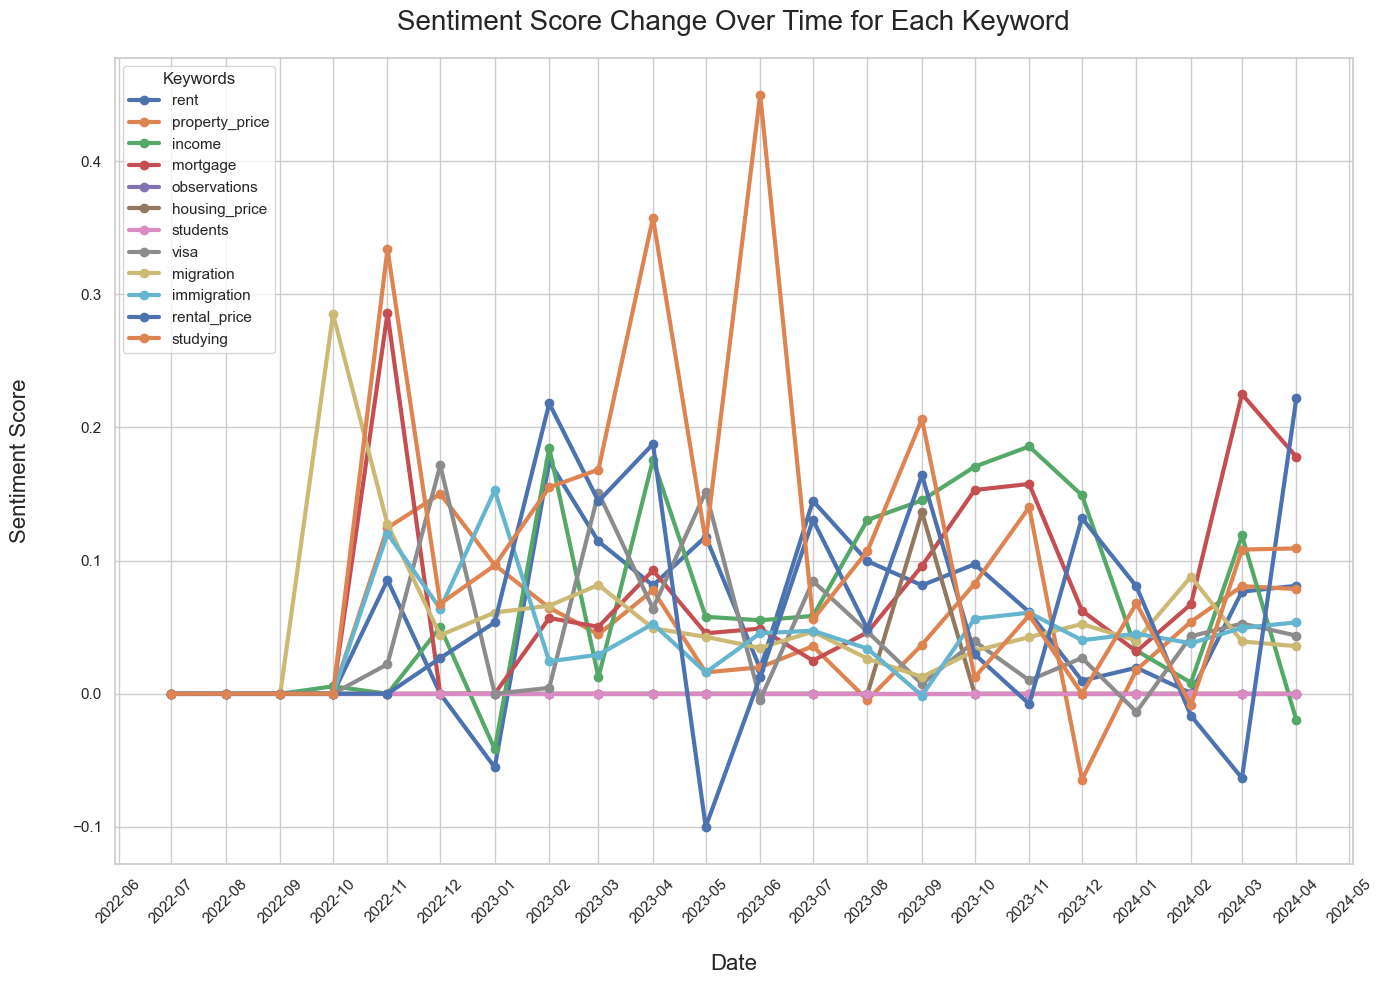

In [51]:
#sentimental score plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import matplotlib.dates as mdates

# Create the plot
plt.figure(figsize=(14, 10))
sns.set(style="whitegrid")
color_palette = sns.color_palette("tab10", len(merged_df['keyword'].unique()))

for keyword in merged_df['keyword'].unique():
    keyword_data = merged_df[merged_df['keyword'] == keyword]
    plt.plot(keyword_data['start_date'], keyword_data['average_polarity'], label=keyword,linewidth=3, marker='o', markersize=6)

plt.xlabel('Date', fontsize=16, labelpad=20)
plt.ylabel('Sentiment Score', fontsize=16, labelpad=30)
plt.title('Sentiment Score Change Over Time for Each Keyword', fontsize=20, pad=20)
plt.legend(title='Keywords', loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout(pad=3.0)

# Set major locator to month intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as an HTML file
html_filename = 'output/sentiment_socre_change_plot.html'
mpld3.save_html(plt.gcf(), html_filename)

print(f"Plot saved as {html_filename}")

Plot saved as output/sentiment_score_count_combined_plot.html


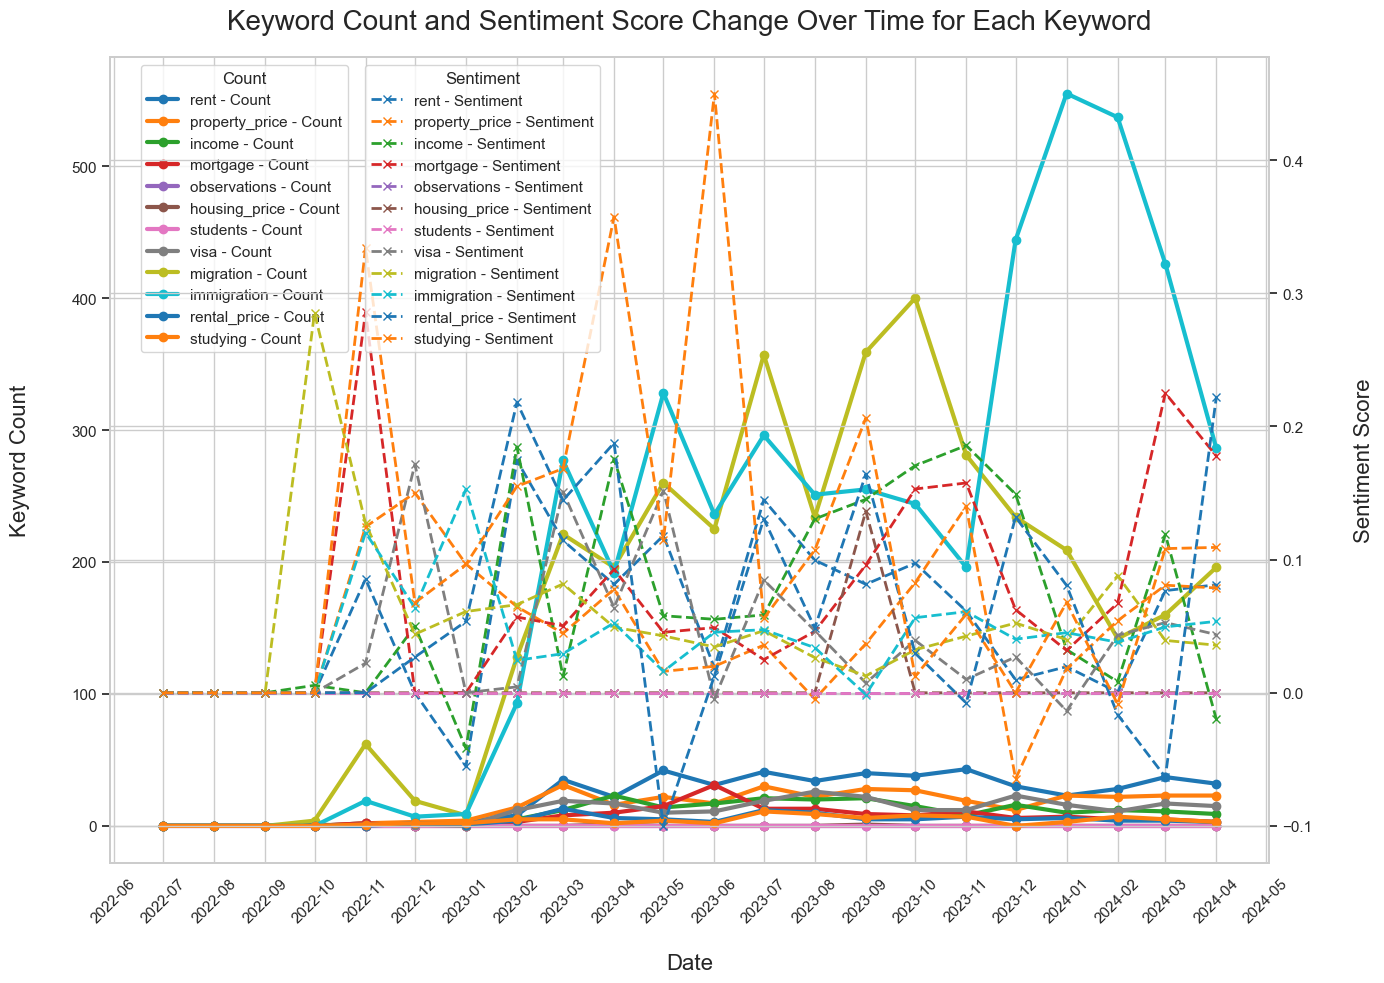

In [52]:
#merged data plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import matplotlib.dates as mdates

color_palette = sns.color_palette("tab10", len(merged_df['keyword'].unique()))

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 10))
sns.set(style="whitegrid")

# Plot keyword count on the primary y-axis
for i, keyword in enumerate(merged_df['keyword'].unique()):
    keyword_data = merged_df[merged_df['keyword'] == keyword]
    ax1.plot(keyword_data['start_date'], keyword_data['count'], label=f"{keyword} - Count", linewidth=3, marker='o', markersize=6, color=color_palette[i])

ax1.set_xlabel('Date', fontsize=16, labelpad=20)
ax1.set_ylabel('Keyword Count', fontsize=16, labelpad=30)
ax1.legend(loc='upper left', bbox_to_anchor=(0.02, 1), title='Count')
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)

# Create secondary y-axis for sentiment score
ax2 = ax1.twinx()

# Plot sentiment score on the secondary y-axis
for i, keyword in enumerate(merged_df['keyword'].unique()):
    keyword_data = merged_df[merged_df['keyword'] == keyword]
    ax2.plot(keyword_data['start_date'], keyword_data['average_polarity'], label=f"{keyword} - Sentiment", linestyle='--', linewidth=2, marker='x', markersize=6, color=color_palette[i])

ax2.set_ylabel('Sentiment Score', fontsize=16, labelpad=30)
ax2.legend(loc='upper left', bbox_to_anchor=(0.22, 0.99), title='Sentiment', borderaxespad=0.)

plt.title('Keyword Count and Sentiment Score Change Over Time for Each Keyword', fontsize=20, pad=20)
plt.tight_layout()

# Save the plot as an HTML file
html_filename = 'output/sentiment_score_count_combined_plot.html'
mpld3.save_html(fig, html_filename)

print(f"Plot saved as {html_filename}")


In [53]:
#highest keyword count content example
import requests
import re
from textblob import TextBlob

# Function to remove HTML tags
def remove_html(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment
    return sentiment.polarity

def fetch_data(keyword, start_date, end_date):
    url = f"http://127.0.0.1:9090/toot/{keyword}?start_date={start_date}&end_date={end_date}&type=raw"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        sentiments = []
        for item in data:
            content = item.get("content", "")
            cleaned_text = remove_html(content)
            sentiment_score = get_sentiment(cleaned_text)
            sentiments.append({
                'content': cleaned_text,
                'sentiment_score': sentiment_score
            })
        if sentiments:
            sentiments.sort(key=lambda x: x['sentiment_score'])
            median_index = len(sentiments) // 2
            return sentiments[0], sentiments[median_index], sentiments[-1]  # Return the lowest and highest sentiment scores
    else:
        print(f"Failed to fetch data for keyword '{keyword}' in date range {start_date} to {end_date}")
        return None, None, None
    
# Fetch the content with the highest and lowest sentiment scores for migration, imigration and visa keywords
lowest_migration, median_migration, highest_migration = fetch_data("migration", "2023-10-01", "2023-10-30")
print(f"Migration Conent with lowest sentiment score: {lowest_migration['content']}, Sentiment score: {lowest_migration['sentiment_score']}")
print(f"Migration Content with median sentiment score: {median_migration['content']}, Sentiment score: {median_migration['sentiment_score']}")
print(f"Migration Content with highest sentiment score: {highest_migration['content']}, Sentiment score: {highest_migration['sentiment_score']}")

print("\n")

lowest_immigration, median_immigarion, highest_immigration = fetch_data("immigration", "2024-01-01", "2024-01-30")
print(f"Immigration Content with lowest sentiment score: {lowest_immigration['content']}, Sentiment score: {lowest_immigration['sentiment_score']}")
print(f"Immigration Content with median sentiment score: {median_immigarion['content']}, Sentiment score: {median_immigarion['sentiment_score']}")
print(f"Immigration Content with highest sentiment score: {highest_immigration['content']}, Sentiment score: {highest_immigration['sentiment_score']}")

print("\n")

lowest_visa, meidan_visa, highest_visa = fetch_data("visa", "2023-08-01", "2023-08-31")
print(f"Content with lowest sentiment score: {lowest_visa['content']}, Sentiment score: {lowest_visa['sentiment_score']}")
print(f"Content with median sentiment score: {meidan_visa['content']}, Sentiment score: {meidan_visa['sentiment_score']}")
print(f"Content with highest sentiment score: {highest_visa['content']}, Sentiment score: {highest_visa['sentiment_score']}")



Migration Conent with lowest sentiment score: Personer som jobbar på #Migrationsverket lär sig  gå i koppel. Ang #sverigedemokraterna ’s våta dröm återvändandecenter säger en kanslichef: [de] ”är inte enbart boende utan en verksamhet där personerna ska ges råd, vägledning och praktiskt stöd för att återvända i större utsträckning än vad som görs idag”Hur har inte råd, vägledning, praktiskt stöd INTE getts hittills? Eller VAD kommer vara skillnaden? Smink på en gris! #Sverige #Svpol #Migration #Migpol https://www.dagensjuridik.se/nyheter/migrationsverket-startar-atervandandecenter-over-600-platser/, Sentiment score: -0.9375
Migration Content with median sentiment score: "Aber was wäre, wenn wir plötzlich die Erleuchtung hätten und ganz plötzlich merken, daß... uns gar nichts fehlt, daß uns niemand etwas weggenommen hat...Daß das alles bloß eine Falle ist, eine Möhre, die man uns vor die Nase gehängt hat, damit wir so blöd sind und den Karren ziehen, müde, schlechtgelaunt, unglücklich un

In [54]:
with open('output/mastodon-content-example.txt', 'w') as f:
    lowest_migration, median_migration, highest_migration = fetch_data("migration", "2023-10-01", "2023-10-30")
    f.write(f"Migration Content with lowest sentiment score: {lowest_migration['content']}, Sentiment score: {lowest_migration['sentiment_score']}\n")
    f.write(f"Migration Content with median sentiment score: {median_migration['content']}, Sentiment score: {median_migration['sentiment_score']}\n")
    f.write(f"Migration Content with highest sentiment score: {highest_migration['content']}, Sentiment score: {highest_migration['sentiment_score']}\n")

    f.write("\n")

    lowest_immigration, median_immigration, highest_immigration = fetch_data("immigration", "2024-01-01", "2024-01-30")
    f.write(f"Immigration Content with lowest sentiment score: {lowest_immigration['content']}, Sentiment score: {lowest_immigration['sentiment_score']}\n")
    f.write(f"Immigration Content with median sentiment score: {median_immigration['content']}, Sentiment score: {median_immigration['sentiment_score']}\n")
    f.write(f"Immigration Content with highest sentiment score: {highest_immigration['content']}, Sentiment score: {highest_immigration['sentiment_score']}\n")

    f.write("\n")

    lowest_visa, meidan_visa, highest_visa = fetch_data("visa", "2023-08-01", "2023-08-31")
    f.write(f"Content with lowest sentiment score: {lowest_visa['content']}, Sentiment score: {lowest_visa['sentiment_score']}\n")
    f.write(f"Content with median sentiment score: {meidan_visa['content']}, Sentiment score: {meidan_visa['sentiment_score']}\n")
    f.write(f"Content with highest sentiment score: {highest_visa['content']}, Sentiment score: {highest_visa['sentiment_score']}\n")
    